<img src="https://raw.githubusercontent.com/Qiskit/qiskit-tutorials/master/images/qiskit-heading.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

## _*E91 quantum key distribution protocol*_
The latest version of this notebook is available on https://github.com/qiskit/qiskit-tutorial.
***
### Contributors
Andrey Kardashin

### Qiskit Package Versions

In [1]:
import qiskit
qiskit.__qiskit_version__

{'qiskit': '0.10.3',
 'qiskit-terra': '0.8.1',
 'qiskit-ignis': '0.1.1',
 'qiskit-aer': '0.2.1',
 'qiskit-ibmq-provider': '0.2.2',
 'qiskit-aqua': '0.5.1'}

## *Introduction*

Suppose that Alice wants to send a message to Bob.
In order to protect the information in the message from the eavesdropper Eve, it must be encrypted.
Encryption is the process of encoding the *plaintext* into *ciphertext*.
The strength of encryption, that is, the property to resist decryption, is determined by its algorithm.
Any encryption algorithm is based on the use of a *key*.
In order to generate the ciphertext, the [one-time pad technique](https://en.wikipedia.org/wiki/One-time_pad) is usually used.

The idea of this technique is to apply the *exclusive or* (XOR) $\oplus$ operation to bits of the plaintext and bits of the key to obtain the ciphertext.
Thus, if $m=(m_1 \ldots m_n)$, $c=(c_1 \ldots c_n)$ and $k=(k_1 \ldots k_n)$ are binary strings of plaintext, ciphertext and key respectively, then the encryption is defined as $c_i=m_i \oplus k_i$, and decryption as $m_i=c_i \oplus k_i$.
![](images/one-time_pad.png)

The one-time pad method is proved to be be absolutely secure.
Thus, if Eve intercepted the ciphertext $c$, she will not get any information from the message $m$ until she has the key $k$.

The main problem of modern cryptographic systems is the distribution among the participants of the communication session of a secret key, possession of which should not be available to third parties.
The rapidly developing methods of quantum key distribution can solve this problem regardless of the capabilities of the eavesdropper.
In this tutorial, we show how Alice and Bob can generate a secret key using the *E91* quantum key distribution protocol.

![alice bobby.png](<attachment:alice bobby.png>)
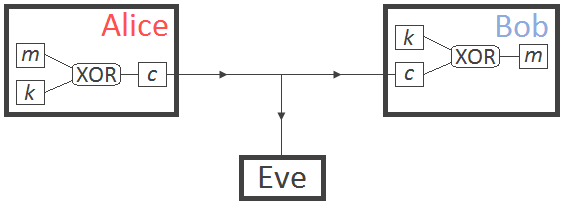

## *Quantum entanglement*

The E91 protocol developed by Artur Ekert in 1991 is based on the use of entangled states and Bell's theorem (see Entanglement Revisited QISKit tutorial).
It is known that two electrons *A* and *B* can be prepared in such a state that they can not be considered separately from each other.
One of these states is the singlet state

$$\lvert\psi_s\rangle =
  \frac{1}{\sqrt{2}}(\lvert0\rangle_A\otimes\lvert1\rangle_B - \lvert1\rangle_A\otimes\lvert0\rangle_B) =
  \frac{1}{\sqrt{2}}(\lvert01\rangle - \lvert10\rangle),$$
  
where the vectors $\lvert 0 \rangle$ and $\lvert 1 \rangle$ describe the states of each electron with the [spin](https://en.wikipedia.org/wiki/Spin_(physics%29) projection along the positive and negative direction of the *z* axis.

The observable of the projection of the spin onto the direction $\vec{n}=(n_x, n_y, n_z)$ is given by

$$\vec{n} \cdot \vec{\sigma} = 
n_x X + n_y Y + n_z Z,$$

where $\vec{\sigma} = (X, Y, Z)$ and $X, Y, Z$ are the Pauli matrices.
For two qubits *A* and *B*, the observable $(\vec{a} \cdot \vec{\sigma})_A \otimes (\vec{b} \cdot \vec{\sigma})_B$ describes the joint measurement of the spin projections onto the directions $\vec{a}$ and $\vec{b}$.
It can be shown that the expectation value of this observable in the singlet state is

$$\langle (\vec{a} \cdot \vec{\sigma})_A \otimes (\vec{b} \cdot \vec{\sigma})_B \rangle_{\psi_s} =
-\vec{a} \cdot \vec{b}. \qquad\qquad (1)$$

Here we see an interesting fact: if Alice and Bob measure the spin projections of electrons A and B onto the same direction, they will obtain the opposite results.
Thus, if Alice got the result $\pm 1$, then Bob *definitely* will get the result $\mp 1$, i.e. the results will be perfectly anticorrelated.

## *CHSH inequality*

In the framework of classical physics, it is impossible to create a correlation inherent in the singlet state $\lvert\psi_s\rangle$.
Indeed, let us measure the observables $X$, $Z$ for qubit *A* and observables $W = \frac{1}{\sqrt{2}} (X + Z)$, $V = \frac{1}{\sqrt{2}} (-X + Z)$ for qubit *B*.
Performing joint measurements of these observables, the following expectation values can be obtained:
\begin{eqnarray*}
 \langle X \otimes W \rangle_{\psi_s} &= -\frac{1}{\sqrt{2}}, \quad 
 \langle X \otimes V \rangle_{\psi_s} &= \frac{1}{\sqrt{2}}, \qquad\qquad (2) \\
 \langle Z \otimes W \rangle_{\psi_s} &= -\frac{1}{\sqrt{2}}, \quad
 \langle Z \otimes V \rangle_{\psi_s} &= -\frac{1}{\sqrt{2}}.
\end{eqnarray*}
Now we can costruct the *Clauser-Horne-Shimony-Holt (CHSH) correlation value*:

$$C =
\langle X\otimes W \rangle - \langle X \otimes V \rangle + \langle Z \otimes W \rangle + \langle Z \otimes V \rangle =
-2 \sqrt{2}. \qquad\qquad (3)$$

The [local hidden variable theory](https://en.wikipedia.org/wiki/Local_hidden_variable_theory) which was developed in particular to explain the quantum correlations gives that $\lvert C \rvert \leqslant 2$.
But [Bell's theorem](https://en.wikipedia.org/wiki/Bell's_theorem) states that "no physical theory of local hidden variables can ever reproduce all of the predictions of quantum mechanics."
Thus, the violation of the [CHSH inequality](https://en.wikipedia.org/wiki/Bell's_theorem#Bell_inequalities_are_violated_by_quantum_mechanical_predictions) (i.e. $C = -2 \sqrt{2}$ for the singlet state), which is a generalized form of Bell's inequality, can serve as an *indicator of quantum entanglement*.
This fact finds its application in the E91 protocol.!

## *The protocol* 

To implement the E91 quantum key distribution protocol, there must be a source of qubits prepared in the singlet state.
It does not matter to whom this source belongs: to Alice, to Bob, to some trusted third-party Charlie or even to Eve.

The steps of the E91 protocol are following.

1. Charlie, the owner of the singlet state preparation device, creates $N$ entangled states $\lvert\psi_s\rangle$ and sends qubits *A* to Alice and qubits *B* to Bob via the quantum channel.
![] ![alice bobby66.png](<attachment:alice bobby66.png>)

2. Participants Alice and Bob generate strings $b=(b_1 \ldots b_N)$ and $b^{'}=(b_1^{'} \ldots b_N^{'})$, where $b_i, b^{'}_j = 1, 2, 3$.
Depending on the elements of these strings, Alice and Bob measure the spin projections of their qubits along the following directions:
\begin{align*}
 b_i = 1: \quad \vec{a}_1 &= (1,0,0) \quad (X \text{ observable}) &
 b_j^{'} = 1: \quad \vec{b}_1 &= \left(\frac{1}{\sqrt{2}},0,\frac{1}{\sqrt{2}}\right) \quad (W \text{ observable})
 \\
 b_i = 2: \quad \vec{a}_2 &= \left(\frac{1}{\sqrt{2}},0,\frac{1}{\sqrt{2}}\right) \quad (W \text{ observable}) &
 b_j^{'} = 2: \quad \vec{b}_2 &= (0,0,1) \quad ( \text{Z observable})
 \\
 b_i = 3: \quad \vec{a}_3 &= (0,0,1) \quad (Z \text{ observable}) &
 b_j^{'} = 3: \quad \vec{b}_3 &= \left(-\frac{1}{\sqrt{2}},0,\frac{1}{\sqrt{2}}\right) \quad (V \text{ observable})
\end{align*}
<img src="images/vectors.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="center">
We can describe this process as a measurement of the observables $(\vec{a}_i \cdot \vec{\sigma})_A \otimes (\vec{b}_j \cdot \vec{\sigma})_B$ for each singlet state created by Charlie.
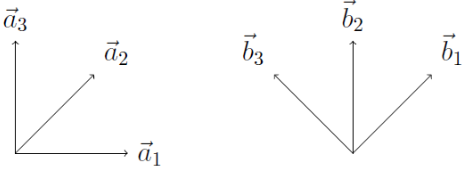

3. Alice and Bob record the results of their measurements as elements of strings $a=(a_1 \ldots a_N)$ and $a^{'} =(a_1^{'} \ldots a_N^{'})$ respectively, where $a_i, a^{'}_j = \pm 1$.

4. Using the classical channel, participants compare their strings $b=(b_1 \ldots b_N)$ and $b^{'}=(b_1^{'} \ldots b_N^{'})$.
In other words, Alice and Bob tell each other which measurements they have performed during the step 2.
If Alice and Bob have measured the spin projections of the $m$-th entangled pair of qubits onto the same direction (i.e. $\vec{a}_2/\vec{b}_1$ or $\vec{a}_3/\vec{b}_2$ for Alice's and Bob's qubit respectively), then they are sure that they obtained opposite results, i.e. $a_m = - a_m^{'}$ (see Eq. (1)).
Thus, for the $l$-th bit of the key strings $k=(k_1 \ldots k_n),k^{'}=(k_1^{'} \ldots k_n^{'})$ Alice and Bob can write $k_l = a_m, k_l^{'} = -a_m^{'}$.
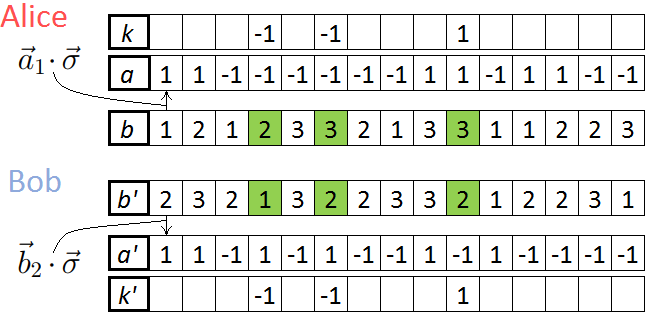

5. Using the results obtained after measuring the spin projections onto the $\vec{a}_1/\vec{b}_1$, $\vec{a}_1/\vec{b}_3$, $\vec{a}_3/\vec{b}_1$ and $\vec{a}_3/\vec{b}_3$ directions (observables $(2)$), Alice and Bob calculate the CHSH correlation value $(3)$.
If $C = -2\sqrt{2}$, then Alice and Bob can be sure that the states they had been receiving from Charlie were entangled indeed.
This fact tells the participants that there was no interference in the quantum channel.
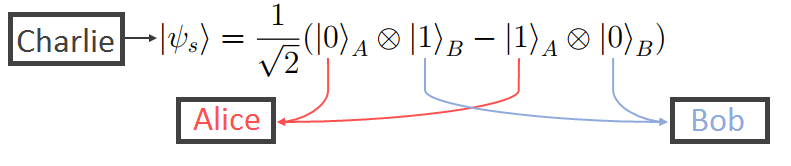

## *Simulation* 

In this section we simulate the E91 quantum key distribution protocol *without* the presence of an eavesdropper.

In [2]:
# useful additional packages 
import numpy as np
import random
# regular expressions module
import re

# importing the QISKit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer

# import basic plot tools
from qiskit.tools.visualization import circuit_drawer, plot_histogram

### *Step one: creating the singlets*

In the first step Alice and Bob receive their qubits of the singlet states $\lvert\psi_s\rangle$ created by Charlie.

For our simulation, we need registers with two quantum bits and four classical bits.

In [3]:
# Creating registers
qr = QuantumRegister(2, name="qr")
cr = ClassicalRegister(4, name="cr")

Let us assume that qubits *qr\[0\]* and *qr\[1\]* belong to Alice and Bob respetively.
In classical bits *cr\[0\]* and *cr\[1\]* Alice and Bob store their measurement results, and classical bits *cr\[2\]* and *cr\[3\]* are used by Eve to store her measurement results of Alice's and Bob's qubits.

Now Charlie creates a singlet state:

In [4]:
singlet = QuantumCircuit(qr, cr, name='singlet')
singlet.x(qr[0])
singlet.x(qr[1])
singlet.h(qr[0])
singlet.cx(qr[0],qr[1])

Qubits *qr\[0\]* and *qr\[1\]* are now entangled.
After creating a singlet state, Charlie sends qubit *qr\[0\]* to Alice and qubit *qr\[1\]* to Bob.
![]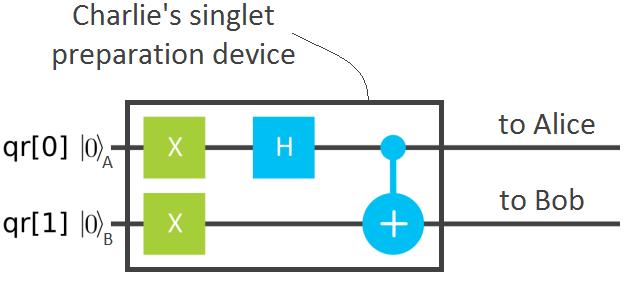

### *Step two: measuring*

First let us prepare the measurements which will be used by Alice and Bob.
We define $A(\vec{a}_i) = \vec{a}_i \cdot \vec{\sigma}$ and $B(\vec{b}_j) = \vec{b}_j \cdot \vec{\sigma}$ as the spin projection observables used by Alice and Bob for their measurements.
To perform these measurements, the standard basis $Z$ must be rotated to the proper basis when it is needed (see [Superposition](https://quantumexperience.ng.bluemix.net/proxy/tutorial/full-user-guide/002-The_Weird_and_Wonderful_World_of_the_Qubit/020-Superposition.html) and [Entanglement and Bell Tests](https://quantumexperience.ng.bluemix.net/proxy/tutorial/full-user-guide/003-Multiple_Qubits_Gates_and_Entangled_States/050-Entanglement_and_Bell_Tests.html) user guides).
Here we define the notation of possible measurements of Alice and Bob: 
![]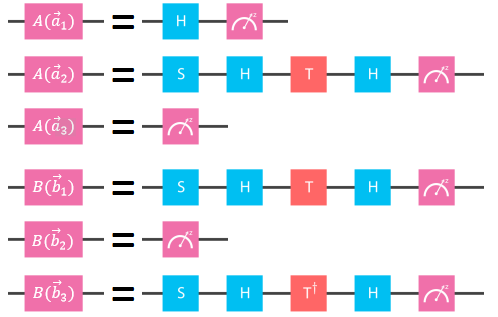

Blocks on the left side can be considered as *detectors* used by the participants to measure $X, W, Z$ and $V$ observables.
Now we prepare the corresponding curcuits.

In [5]:
## Alice's measurement circuits

# measure the spin projection of Alice's qubit onto the a_1 direction (X basis)
measureA1 = QuantumCircuit(qr, cr, name='measureA1')
measureA1.h(qr[0])
measureA1.measure(qr[0],cr[0])

# measure the spin projection of Alice's qubit onto the a_2 direction (W basis)
measureA2 = QuantumCircuit(qr, cr, name='measureA2')
measureA2.s(qr[0])
measureA2.h(qr[0])
measureA2.t(qr[0])
measureA2.h(qr[0])
measureA2.measure(qr[0],cr[0])

# measure the spin projection of Alice's qubit onto the a_3 direction (standard Z basis)
measureA3 = QuantumCircuit(qr, cr, name='measureA3')
measureA3.measure(qr[0],cr[0])

## Bob's measurement circuits

# measure the spin projection of Bob's qubit onto the b_1 direction (W basis)
measureB1 = QuantumCircuit(qr, cr, name='measureB1')
measureB1.s(qr[1])
measureB1.h(qr[1])
measureB1.t(qr[1])
measureB1.h(qr[1])
measureB1.measure(qr[1],cr[1])

# measure the spin projection of Bob's qubit onto the b_2 direction (standard Z basis)
measureB2 = QuantumCircuit(qr, cr, name='measureB2')
measureB2.measure(qr[1],cr[1])

# measure the spin projection of Bob's qubit onto the b_3 direction (V basis)
measureB3 = QuantumCircuit(qr, cr, name='measureB3')
measureB3.s(qr[1])
measureB3.h(qr[1])
measureB3.tdg(qr[1])
measureB3.h(qr[1])
measureB3.measure(qr[1],cr[1])

## Lists of measurement circuits
aliceMeasurements = [measureA1, measureA2, measureA3]
bobMeasurements = [measureB1, measureB2, measureB3]

Supose Alice and Bob want to generate a secret key using $N$ singlet states prepared by Charlie. 

In [6]:
# Define the number of singlets N
numberOfSinglets = 500

The participants must choose the directions onto which they will measure the spin projections of their qubits.
To do this, Alice and Bob create the strings $b$ and $b^{'}$ with randomly generated elements.

In [7]:
aliceMeasurementChoices = [random.randint(1, 3) for i in range(numberOfSinglets)] # string b of Alice
bobMeasurementChoices = [random.randint(1, 3) for i in range(numberOfSinglets)] # string b' of Bob

Now we combine Charlie's device and Alice's and Bob's detectors into one circuit (singlet + Alice's measurement + Bob's measurement).

In [8]:
circuits = [] # the list in which the created circuits will be stored

for i in range(numberOfSinglets):
    # create the name of the i-th circuit depending on Alice's and Bob's measurement choices
    circuitName = str(i) + ':A' + str(aliceMeasurementChoices[i]) + '_B' + str(bobMeasurementChoices[i])
    
    # create the joint measurement circuit
    # add Alice's and Bob's measurement circuits to the singlet state curcuit
    # singlet state circuit # measurement circuit of Alice # measurement circuit of Bob
    circuitName = singlet + aliceMeasurements[aliceMeasurementChoices[i]-1] + bobMeasurements[bobMeasurementChoices[i]-1] 
    
    # add the created circuit to the circuits list
    circuits.append(circuitName)

Let us look at the name of one of the prepared circuits.

In [9]:
print(circuits[0].name)

circuit8


It tells us about the number of the singlet state received from Charlie, and the measurements applied by Alice and Bob.

In the *circuits* list we have stored $N$ (*numberOfSinglets*) circuits similar to those shown in the figure below.
![]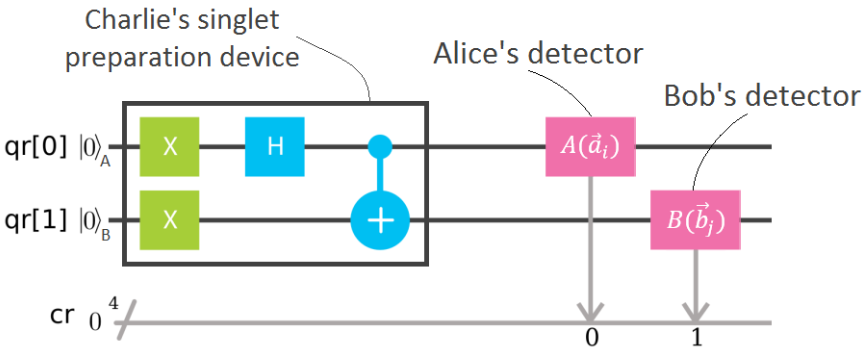

The idea is to model every act of the creation of the singlet state, the distribution of its qubits among the participants and the measurement of the spin projection onto the chosen direction in the E91 protocol by executing each circuit from the *circuits* list with one shot.

### *Step three: recording the results*

First let us execute the circuits on the simulator.

In [10]:
backend=BasicAer.get_backend('qasm_simulator')
result = execute(circuits, backend=backend, shots=1).result()  
#print(result) # uncomment for detailed result

Look at the output of the execution of the first circuit.

In [11]:
result.get_counts(circuits[0])

{'0011': 1}

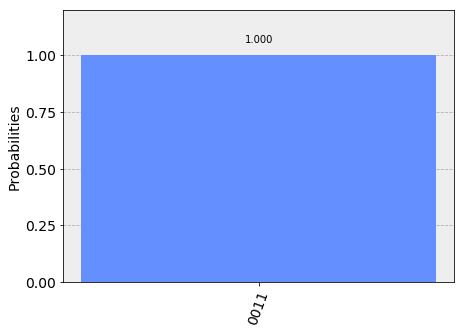

In [12]:
plot_histogram(result.get_counts(circuits[0]))

It consists of four digits.
Recall that Alice and Bob store the results of the measurement in classical bits *cr\[0\]* and *cr\[1\]* (two digits on the right).
Since we model the secret key generation process without the presence of an eavesdropper, the classical bits *cr\[2\]* and *cr\[3\]* are always 0.
Also note that the output is the Python dictionary, in which the keys are the obtained results, and the values are the counts.

Alice and Bob record the results of their measurements as bits of the strings $a$ and $a^{'}$.
To simulate this process we need to use regular expressions module *[re](https://docs.python.org/3/howto/regex.html#regex-howto)*.
First, we compile the search patterns.

In [13]:
abPatterns = [
    re.compile('..00$'), # search for the '..00' output (Alice obtained -1 and Bob obtained -1)
    re.compile('..01$'), # search for the '..01' output
    re.compile('..10$'), # search for the '..10' output (Alice obtained -1 and Bob obtained 1)
    re.compile('..11$')  # search for the '..11' output
]

Using these patterns, we can find particular results in the outputs and fill strings the $a$ and $a^{'}$ with the results of Alice's and Bob's measurements.

In [14]:
aliceResults = [] # Alice's results (string a)
bobResults = [] # Bob's results (string a')

for i in range(numberOfSinglets):

    res = list(result.get_counts(circuits[i]).keys())[0] # extract the key from the dict and transform it to str; execution result of the i-th circuit
    
    if abPatterns[0].search(res): # check if the key is '..00' (if the measurement results are -1,-1)
        aliceResults.append(-1) # Alice got the result -1 
        bobResults.append(-1) # Bob got the result -1
    if abPatterns[1].search(res):
        aliceResults.append(1)
        bobResults.append(-1)
    if abPatterns[2].search(res): # check if the key is '..10' (if the measurement results are -1,1)
        aliceResults.append(-1) # Alice got the result -1 
        bobResults.append(1) # Bob got the result 1
    if abPatterns[3].search(res): 
        aliceResults.append(1)
        bobResults.append(1)

### *Step four: revealing the bases*

In the previos step we have stored the measurement results of Alice and Bob in the *aliceResults* and *bobResults* lists (strings $a$ and $a^{'}$).
Now the participants compare their strings $b$ and $b^{'}$ via the public classical channel.
If Alice and Bob have measured the spin projections of their qubits of the *i*-th singlet onto the same direction, then Alice records the result $a_i$ as the bit of the string $k$, and Bob records the result $-a_i$ as the bit of the string $k^{'}$ (see Eq. (1)).

In [15]:
aliceKey = [] # Alice's key string k
bobKey = [] # Bob's key string k'

# comparing the stings with measurement choices
for i in range(numberOfSinglets):
    # if Alice and Bob have measured the spin projections onto the a_2/b_1 or a_3/b_2 directions
    if (aliceMeasurementChoices[i] == 2 and bobMeasurementChoices[i] == 1) or (aliceMeasurementChoices[i] == 3 and bobMeasurementChoices[i] == 2):
        aliceKey.append(aliceResults[i]) # record the i-th result obtained by Alice as the bit of the secret key k
        bobKey.append(- bobResults[i]) # record the multiplied by -1 i-th result obtained Bob as the bit of the secret key k'
        
keyLength = len(aliceKey) # length of the secret key

The keys $k$ and $k'$ are now stored in the *aliceKey* and *bobKey* lists, respectively.
The remaining results which were not used to create the keys can now be revealed.

It is important for Alice and Bob to have the same keys, i.e. strings $k$ and $k^{'}$ must be equal.
Let us compare the bits of strings $k$ and $k^{'}$ and find out how many there are mismatches in the keys.

In [16]:
abKeyMismatches = 0 # number of mismatching bits in Alice's and Bob's keys

for j in range(keyLength):
    if aliceKey[j] != bobKey[j]:
        abKeyMismatches += 1

Note that since the strings $k$ and $k^{'}$ are secret, Alice and Bob have no information about mismatches in the bits of their keys.
To find out the number of errors, the participants can perform a random sampling test.
Alice randomly selects $\delta$ bits of her secret key and tells Bob which bits she selected.
Then Alice and Bob compare the values of these check bits.
For large enough $\delta$ the number of errors in the check bits will be close to the number of errors in the remaining bits.

### *Step five: CHSH correlation value test*

Alice and Bob want to be sure that there was no interference in the communication session.
To do that, they calculate the CHSH correlation value $(3)$ using the results obtained after the measurements of spin projections onto the $\vec{a}_1/\vec{b}_1$, $\vec{a}_1/\vec{b}_3$, $\vec{a}_3/\vec{b}_1$ and $\vec{a}_3/\vec{b}_3$ directions.
Recall that it is equivalent to the measurement of the observables $X \otimes W$, $X \otimes V$, $Z \otimes W$ and $Z \otimes V$ respectively.

According to the Born-von Neumann statistical postulate, the expectation value of the observable $E = \sum_j e_j \lvert e_j \rangle \langle e_j \rvert$ in the state $\lvert \psi \rangle$ is given by

$$\langle E \rangle_\psi =
  \mathrm{Tr}\, \lvert\psi\rangle \langle\psi\rvert \, E = \\
  \mathrm{Tr}\, \lvert\psi\rangle \langle\psi\rvert \sum_j e_j \lvert e_j \rangle \langle e_j \rvert  = 
  \sum_j \langle\psi\rvert(e_j \lvert e_j \rangle \langle e_j \rvert) \lvert\psi\rangle = 
  \sum_j e_j \left|\langle\psi\lvert e_j \rangle \right|^2 = \\
  \sum_j e_j \mathrm{P}_\psi (E \models e_j),$$
where $\lvert e_j \rangle$ is the eigenvector of $E$ with the corresponding eigenvalue $e_j$, and $\mathrm{P}_\psi (E \models e_j)$ is the probability of obtainig the result $e_j$ after measuring the observable $E$ in the state $\lvert \psi \rangle$.

A similar expression can be written for the joint measurement of the observables $A$ and $B$:

$$\langle A \otimes B \rangle_\psi =
  \sum_{j,k} a_j b_k \mathrm{P}_\psi (A \models a_j, B \models b_k) =
  \sum_{j,k} a_j b_k \mathrm{P}_\psi (a_j, b_k). \qquad\qquad (4)$$
 
Note that if $A$ and $B$ are the spin projection observables, then the corresponding eigenvalues are $a_j, b_k = \pm 1$.
Thus, for the observables $A(\vec{a}_i)$ and $B(\vec{b}_j)$ and singlet state $\lvert\psi\rangle_s$ we can rewrite $(4)$ as

$$\langle A(\vec{a}_i) \otimes B(\vec{b}_j) \rangle =
  \mathrm{P}(-1,-1) - \mathrm{P}(1,-1) - \mathrm{P}(-1,1) + \mathrm{P}(1,1). \qquad\qquad (5)$$

In our experiments, the probabilities on the right side can be calculated as follows:

$$\mathrm{P}(a_j, b_k) = \frac{n_{a_j, b_k}(A \otimes B)}{N(A \otimes B)}, \qquad\qquad (6)$$

where the numerator is the number of results $a_j, b_k$ obtained after measuring the observable $A \otimes B$, and the denominator is the total number of measurements of the observable $A \otimes B$.

Since Alice and Bob revealed their strings $b$ and $b^{'}$, they know what measurements they performed and what results they have obtained.
With this data, participants calculate the expectation values $(2)$ using $(5)$ and $(6)$.

In [17]:
# function that calculates CHSH correlation value
def chsh_corr(result):
    
    # lists with the counts of measurement results
    # each element represents the number of (-1,-1), (-1,1), (1,-1) and (1,1) results respectively
    countA1B1 = [0, 0, 0, 0] # XW observable
    countA1B3 = [0, 0, 0, 0] # XV observable
    countA3B1 = [0, 0, 0, 0] # ZW observable
    countA3B3 = [0, 0, 0, 0] # ZV observable

    for i in range(numberOfSinglets):

        res = list(result.get_counts(circuits[i]).keys())[0]

        # if the spins of the qubits of the i-th singlet were projected onto the a_1/b_1 directions
        if (aliceMeasurementChoices[i] == 1 and bobMeasurementChoices[i] == 1):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA1B1[j] += 1

        if (aliceMeasurementChoices[i] == 1 and bobMeasurementChoices[i] == 3):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA1B3[j] += 1

        if (aliceMeasurementChoices[i] == 3 and bobMeasurementChoices[i] == 1):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA3B1[j] += 1
                    
        # if the spins of the qubits of the i-th singlet were projected onto the a_3/b_3 directions
        if (aliceMeasurementChoices[i] == 3 and bobMeasurementChoices[i] == 3):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA3B3[j] += 1
                    
    # number of the results obtained from the measurements in a particular basis
    total11 = sum(countA1B1)
    total13 = sum(countA1B3)
    total31 = sum(countA3B1)
    total33 = sum(countA3B3)      
                    
    # expectation values of XW, XV, ZW and ZV observables (2)
    expect11 = (countA1B1[0] - countA1B1[1] - countA1B1[2] + countA1B1[3])/total11 # -1/sqrt(2)
    expect13 = (countA1B3[0] - countA1B3[1] - countA1B3[2] + countA1B3[3])/total13 # 1/sqrt(2)
    expect31 = (countA3B1[0] - countA3B1[1] - countA3B1[2] + countA3B1[3])/total31 # -1/sqrt(2)
    expect33 = (countA3B3[0] - countA3B3[1] - countA3B3[2] + countA3B3[3])/total33 # -1/sqrt(2) 
    
    corr = expect11 - expect13 + expect31 + expect33 # calculate the CHSC correlation value (3)
    
    return corr

### *Output*

Now let us print all the interesting values.

In [18]:
corr = chsh_corr(result) # CHSH correlation value

# CHSH inequality test
print('CHSH correlation value: ' + str(round(corr, 3)))

# Keys
print('Length of the key: ' + str(keyLength))
print('Number of mismatching bits: ' + str(abKeyMismatches) + '\n')

CHSH correlation value: -2.612
Length of the key: 112
Number of mismatching bits: 0



Finaly, Alice and Bob have the secret keys $k$ and $k^{'}$ (*aliceKey* and *bobKey*)!
Now they can use the one-time pad technique to encrypt and decrypt messages.

Since we simulate the E91 protocol without the presence of Eve, the CHSH correlation value should be close to $-2\sqrt{2} \approx -2.828$.
In addition, there should be no mismatching bits in the keys of Alice and Bob.
Note also that there are 9 possible combinations of measurements that can be performed by Alice and Bob, but only 2 of them give the results using which the secret keys can be created.
Thus, the ratio of the length of the keys to the number of singlets $N$ should be close to $2/9$.

## *Simulation of eavesdropping*

Suppose some third party wants to interfere in the communication session of Alice and Bob and obtain a secret key.
The eavesdropper can use the *intercept-resend* attacks: Eve intercepts one or both of the entangled qubits prepared by Charlie, measures the spin projections of these qubits, prepares new ones depending on the results obtained ($\lvert 01 \rangle$ or $\lvert 10 \rangle$) and sends them to Alice and Bob.
A schematic representation of this process is shown in the figure below.
![]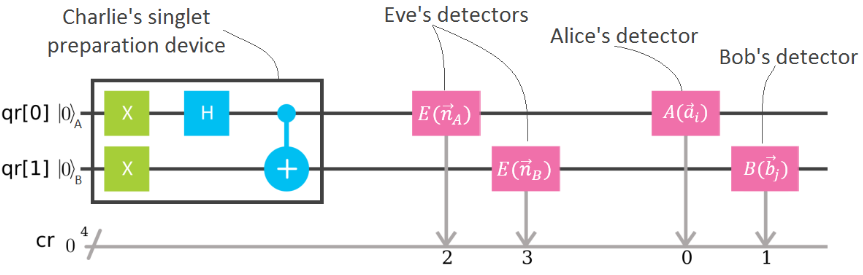

Here $E(\vec{n}_A) = \vec{n}_A \cdot \vec{\sigma}$ and $E(\vec{n}_B) = \vec{n}_A \cdot \vec{\sigma}$ are the observables of the of the spin projections of Alice's and Bob's qubits onto the directions $\vec{n}_A$ and $\vec{n}_B$.
It would be wise for Eve to choose these directions to be $\vec{n}_A = \vec{a}_2,\vec{a}_3$ and $\vec{n}_B = \vec{b}_1,\vec{b}_2$ since the results obtained from other measurements can not be used to create a secret key.

Let us prepare the circuits for Eve's measurements.

In [19]:
# measurement of the spin projection of Alice's qubit onto the a_2 direction (W basis)
measureEA2 = QuantumCircuit(qr, cr, name='measureEA2')
measureEA2.s(qr[0])
measureEA2.h(qr[0])
measureEA2.t(qr[0])
measureEA2.h(qr[0])
measureEA2.measure(qr[0],cr[2])

# measurement of the spin projection of Allice's qubit onto the a_3 direction (standard Z basis)
measureEA3 = QuantumCircuit(qr, cr, name='measureEA3')
measureEA3.measure(qr[0],cr[2])

# measurement of the spin projection of Bob's qubit onto the b_1 direction (W basis)
measureEB1 = QuantumCircuit(qr, cr, name='measureEB1')
measureEB1.s(qr[1])
measureEB1.h(qr[1])
measureEB1.t(qr[1])
measureEB1.h(qr[1])
measureEB1.measure(qr[1],cr[3])

# measurement of the spin projection of Bob's qubit onto the b_2 direction (standard Z measurement)
measureEB2 = QuantumCircuit(qr, cr, name='measureEB2')
measureEB2.measure(qr[1],cr[3])

# lists of measurement circuits
eveMeasurements = [measureEA2, measureEA3, measureEB1, measureEB2]

Like Alice and Bob, Eve must choose the directions onto which she will measure the spin projections of the qubits.
In our simulation, the eavesdropper randomly chooses one of the observables $W \otimes W$ or $Z \otimes Z$ to measure.

In [20]:
# list of Eve's measurement choices
# the first and the second elements of each row represent the measurement of Alice's and Bob's qubits by Eve respectively
eveMeasurementChoices = []

for j in range(numberOfSinglets):      
    if random.uniform(0, 1) <= 0.5: # in 50% of cases perform the WW measurement
        eveMeasurementChoices.append([0, 2])
    else: # in 50% of cases perform the ZZ measurement
        eveMeasurementChoices.append([1, 3])

Like we did before, now we create the circuits with singlet states and detectors of Eve, Alice and Bob. 

In [21]:
circuits = [] # the list in which the created circuits will be stored

for j in range(numberOfSinglets):
    # create the name of the j-th circuit depending on Alice's, Bob's and Eve's choices of measurement
    circuitName = str(j) + ':A' + str(aliceMeasurementChoices[j]) + '_B' + str(bobMeasurementChoices[j] + 2) + '_E' + str(eveMeasurementChoices[j][0]) + str(eveMeasurementChoices[j][1] - 1)
    
    # create the joint measurement circuit
    # add Alice's and Bob's measurement circuits to the singlet state curcuit
    # singlet state circuit # Eve's measurement circuit of Alice's qubit # Eve's measurement circuit of Bob's qubit # measurement circuit of Alice # measurement circuit of Bob
    circuitName = singlet + eveMeasurements[eveMeasurementChoices[j][0]-1] + eveMeasurements[eveMeasurementChoices[j][1]-1] + aliceMeasurements[aliceMeasurementChoices[j]-1] +  bobMeasurements[bobMeasurementChoices[j]-1]
    
    # add the created circuit to the circuits list
    circuits.append(circuitName)

Now we execute all the prepared circuits on the simulator.

In [22]:
backend=BasicAer.get_backend('qasm_simulator')
result = execute(circuits, backend=backend, shots=1).result()
# print(result) # uncomment for detailed result

Let us look at the name of the first circuit and the output after it is executed.

In [23]:
print(str(circuits[0].name) + '\t' + str(result.get_counts(circuits[0])))

circuit1514	{'0100': 1}


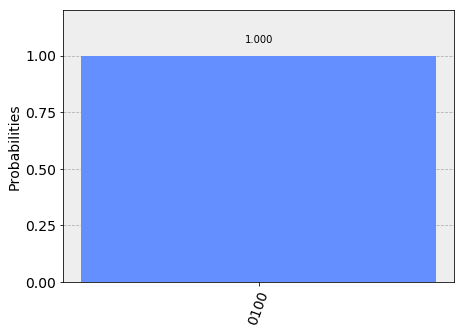

In [24]:
plot_histogram(result.get_counts(circuits[0]))

We can see onto which directions Eve, Alice and Bob measured the spin projections and the results obtained.
Recall that the bits *cr\[2\]* and *cr\[3\]* (two digits on the left) are used by Eve to store the results of her measurements.

To extract Eve's results from the outputs, we need to compile new search patterns.

In [25]:
ePatterns = [
    re.compile('00..$'), # search for the '00..' result (Eve obtained the results -1 and -1 for Alice's and Bob's qubits)
    re.compile('01..$'), # search for the '01..' result (Eve obtained the results 1 and -1 for Alice's and Bob's qubits)
    re.compile('10..$'),
    re.compile('11..$')  
]

Now Eve, Alice and Bob record the results of their measurements.

In [26]:
aliceResults = [] # Alice's results (string a)
bobResults = [] # Bob's results (string a')

# list of Eve's measurement results
# the elements in the 1-st column are the results obtaned from the measurements of Alice's qubits
# the elements in the 2-nd column are the results obtaned from the measurements of Bob's qubits
eveResults = [] 

# recording the measurement results
for j in range(numberOfSinglets):
    
    res = list(result.get_counts(circuits[j]).keys())[0] # extract a key from the dict and transform it to str
    
    # Alice and Bob
    if abPatterns[0].search(res): # check if the key is '..00' (if the measurement results are -1,-1)
        aliceResults.append(-1) # Alice got the result -1 
        bobResults.append(-1) # Bob got the result -1
    if abPatterns[1].search(res):
        aliceResults.append(1)
        bobResults.append(-1)
    if abPatterns[2].search(res): # check if the key is '..10' (if the measurement results are -1,1)
        aliceResults.append(-1) # Alice got the result -1 
        bobResults.append(1) # Bob got the result 1
    if abPatterns[3].search(res): 
        aliceResults.append(1)
        bobResults.append(1)

    # Eve
    if ePatterns[0].search(res): # check if the key is '00..'
        eveResults.append([-1, -1]) # results of the measurement of Alice's and Bob's qubits are -1,-1
    if ePatterns[1].search(res):
        eveResults.append([1, -1])
    if ePatterns[2].search(res):
        eveResults.append([-1, 1])
    if ePatterns[3].search(res):
        eveResults.append([1, 1])

As before, Alice, Bob and Eve create the secret keys using the results obtained after measuring the observables $W \otimes W$ and $Z \otimes Z$.

In [27]:
aliceKey = [] # Alice's key string a
bobKey = [] # Bob's key string a'
eveKeys = [] # Eve's keys; the 1-st column is the key of Alice, and the 2-nd is the key of Bob

# comparing the strings with measurement choices (b and b')
for j in range(numberOfSinglets):
    # if Alice and Bob measured the spin projections onto the a_2/b_1 or a_3/b_2 directions
    if (aliceMeasurementChoices[j] == 2 and bobMeasurementChoices[j] == 1) or (aliceMeasurementChoices[j] == 3 and bobMeasurementChoices[j] == 2):  
        aliceKey.append(aliceResults[j]) # record the i-th result obtained by Alice as the bit of the secret key k
        bobKey.append(-bobResults[j]) # record the multiplied by -1 i-th result obtained Bob as the bit of the secret key k'
        eveKeys.append([eveResults[j][0], -eveResults[j][1]]) # record the i-th bits of the keys of Eve 

keyLength = len(aliceKey) # length of the secret skey

To find out the number of mismatching bits in the keys of Alice, Bob and Eve we compare the lists *aliceKey*, *bobKey* and *eveKeys*.

In [28]:
abKeyMismatches = 0 # number of mismatching bits in the keys of Alice and Bob
eaKeyMismatches = 0 # number of mismatching bits in the keys of Eve and Alice
ebKeyMismatches = 0 # number of mismatching bits in the keys of Eve and Bob

for j in range(keyLength):
    if aliceKey[j] != bobKey[j]: 
        abKeyMismatches += 1
    if eveKeys[j][0] != aliceKey[j]:
        eaKeyMismatches += 1
    if eveKeys[j][1] != bobKey[j]:
        ebKeyMismatches += 1

It is also good to know what percentage of the keys is known to Eve.

In [29]:
eaKnowledge = (keyLength - eaKeyMismatches)/keyLength # Eve's knowledge of Bob's key
ebKnowledge = (keyLength - ebKeyMismatches)/keyLength # Eve's knowledge of Alice's key

Using the *chsh_corr* function defined above we calculate the CSHS correlation value.

In [30]:
corr = chsh_corr(result)

And now we print all the results.

In [31]:
# CHSH inequality test
print('CHSH correlation value: ' + str(round(corr, 3)) + '\n')

# Keys
print('Length of the key: ' + str(keyLength))
print('Number of mismatching bits: ' + str(abKeyMismatches) + '\n')

print('Eve\'s knowledge of Alice\'s key: ' + str(round(eaKnowledge * 100, 2)) + ' %')
print('Eve\'s knowledge of Bob\'s key: ' + str(round(ebKnowledge * 100, 2)) + ' %')

CHSH correlation value: -1.821

Length of the key: 112
Number of mismatching bits: 11

Eve's knowledge of Alice's key: 94.64 %
Eve's knowledge of Bob's key: 91.96 %


Due to Eve's interference in the communication session, the CHSH correlation value is far away from $-2 \sqrt{2}$.
Alice and Bob see it and will not use the secret key to encrypt and decrypt any messages.
It has been shown by Ekert that for any eavesdropping strategy and for any directions $\vec{n}_A$, $\vec{n}_B$ onto which Eve measures the spin projections of Alice's and Bob's qubits the following inequality can be written:

$$ -\sqrt{2} \leqslant C \leqslant \sqrt{2},$$

where $C$ is CHSH correlation value (3).
The more Eve interferes in the communication session, the more she knows about the secret keys.
But at the same time, the deviation of the CHSH correlation value from $-2\sqrt{2}$ also increases.

We can see that there are the mismatches in the keys of Alice and Bob.
Where do they come from?
After Eve measures the qubits of the singlet state $\lvert \psi_s \rangle$, she randomly obtains the results $-1,1$ or $1,-1$ (see Eq. (1)).
Depending on the results obtained, the eavesdropper prepares the state $\lvert \varphi_1 \rangle = \lvert 01 \rangle$ or $\lvert \varphi_2 \rangle = \lvert 10 \rangle$ (in our simulation it is automatically provided by a measurement in the $Z$ basis) and sends its qubits to Alice and Bob.
When Alice and Bob measure the observable $W \otimes W$, they obtain any combination of results with probability $\mathrm{P}_{\varphi_{n}}(a_i, b_j)$.
To see this, one can compare the results of the execution of Quantum Scores of [$W_E \otimes W_E \vert W_A \otimes W_B$](https://quantumexperience.ng.bluemix.net/share/code/1c4d96685cb20c2b99e43f9999b28313/execution/917dca7c81dfda7886af97eef85d5946) and [$W_E \otimes W_E \vert Z_A \otimes Z_B$](https://quantumexperience.ng.bluemix.net/share/code/0d378f5f16990ab3e47546ae4b0c39d2/execution/e836b67e10e9d11d7828a67a834cf4fd) measurements (the subscripts denote who performs the measurement).

In order to correct the mismatches in the keys of Alice and Bob classical error reconciliation algorithms are used.
A very good description of the error correction methods can be found in [Quantum cryptography](https://arxiv.org/abs/quant-ph/0101098) by N. Gisin et al.